# YouTube trending videos

In [91]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import string
from pandas.plotting import scatter_matrix

from categories import get_categories_dict

## Etap 1 - Atrybuty tekstowe

W obu zbiorach danych występują następujące atrybuty:
- **video_id** - identyfikator filmu
- **trending_date** - data pojawienia się w sekcji "trending"
- **title** - tytuł filmu,
- **channel_title** - nazwa kanału,
- **category_id** - identyfikator kategorii w do jakiego należy film,
- **publish_time** - data publikacji filmu,
- **tags** - tagi, którymi został oznaczony film,
- **views** - liczba wyświetleń filmu,
- **likes** - liczba polubień filmu,
- **dislikes** - liczba zaznaczeń "Nie podoba mi się" danego filmu,
- **comment_count** - liczba komentarzy pod filmem,
- **thumbnail_link** - url prowadzący do obrazka filmu,
- **comments_disabled** - zmienna logiczna wskazująca na zabronienie komentowania filmu,
- **ratings_disabled** - zmienna logiczna wskazująca na zabronienie oceniania filmu,
- **video_error_or_removed** - zmienna logiczna wskazująca na błąd w filmie lub jego usunięcie,
- **description** - opis filmu

### Wczytanie danych

In [92]:
gb_videos = pd.read_csv(os.path.join("youtube_data", "GB_videos_5p.csv"), sep=";")
us_videos = pd.read_csv(os.path.join("youtube_data", "US_videos_5p.csv"), sep=";")
videos = pd.concat([gb_videos, us_videos])
videos = videos.rename(columns={"description ":"description"})
videos.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,NaN,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,NaN,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...
5,AumaWl0TNBo,17.14.11,How My Relationship Started!,PointlessBlogVlogs,NaN,2017-11-11T17:00:00.000Z,"pointlessblog|""pointlessblogtv""|""pointlessblog...",1182775,52708,1431,2333,https://i.ytimg.com/vi/AumaWl0TNBo/default.jpg,False,False,False,► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...
6,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,NaN,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634124,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
7,#NAZWA?,17.14.11,CHRISTMAS HAS GONE TO MY HEAD,MoreZoella,NaN,2017-11-10T19:19:43.000Z,"zoe sugg|""zoella""|""zoe""|""vlog""|""vlogging""|""vlo...",1164201,57309,749,624,https://i.ytimg.com/vi/-N5eucPMTTc/default.jpg,False,False,False,CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...
8,LMCuKltaY3M,17.14.11,Elbow - Golden Slumbers (John Lewis Advert 2017),ElbowVEVO,NaN,2017-11-10T08:00:01.000Z,"Elbow|""Golden""|""Slumbers""|""Polydor""|""Alternative""",154494,2163,147,211,https://i.ytimg.com/vi/LMCuKltaY3M/default.jpg,False,False,False,"“Golden Slumbers”, originally by The Beatles, ..."
9,9t9u_yPEidY,17.14.11,"Jennifer Lopez - Amor, Amor, Amor (Official Vi...",JenniferLopezVEVO,NaN,2017-11-10T15:00:00.000Z,"Jennifer Lopez ft. Wisin|""Jennifer Lopez ft. W...",9548677,190084,15015,11473,https://i.ytimg.com/vi/9t9u_yPEidY/default.jpg,False,False,False,"Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O..."


## TODO preprocessing tagów pod filmami

warto zwrócić uwagę że już 3 miejsce pod względem liczności to filmy bez tagów !!

In [93]:
# TAGS PREPROCESSING
videos["tags"] = videos["tags"].str.replace('"', "")
tags = videos["tags"].str.split("|").apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.name = "tags"
tags = tags.to_frame()
unique_tags = tags["tags"].value_counts() #
unique_tags = unique_tags.rename_axis("tag").reset_index(name="count")
unique_tags.describe()

,count
count,72467.000000
mean,20.818055
std,67.668262
min,1.000000
25%,5.000000
50%,9.000000
75%,18.000000
max,6232.000000


                                 tag  count
0                              funny   6232
1                             comedy   5253
2                             [none]   3545
3                              music   3274
4                                Pop   2836
...                              ...    ...
72462                       Subject)      1
72463  eagles vs patriots highlights      1
72464              Ocean Exploration      1
72465                     e-mobility      1
72466                          karen      1

[72467 rows x 2 columns]


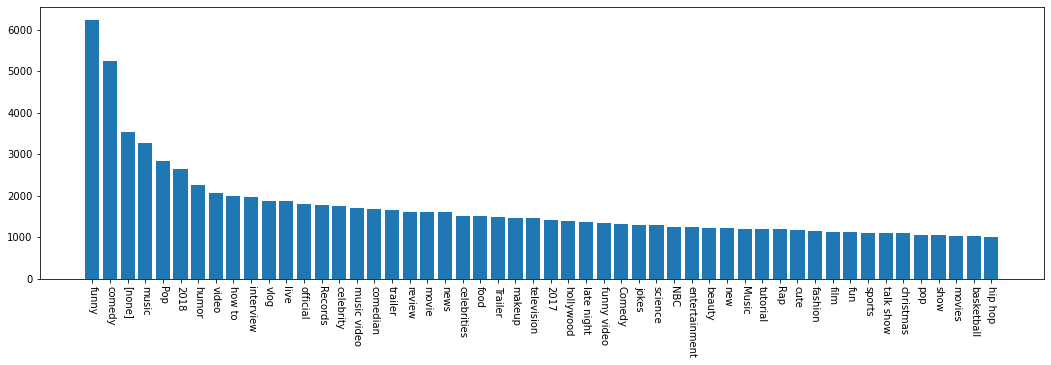

In [94]:
print(unique_tags)
unique_tags = unique_tags[unique_tags["count"] > 1000]
plt.subplots(figsize=(18,5))
plt.bar(unique_tags["tag"], unique_tags["count"])
plt.xticks(rotation=270)
plt.show()

# plt.bar()
# plt.show()

# gb_videos.head(20)

### Preprocessing tytułów kanałów

In [95]:
channel_titles = videos["channel_title"]
unique_channel_titles = videos["channel_title"].value_counts()
unique_channel_titles = unique_channel_titles.rename_axis("channel_title").reset_index(name="count")
unique_channel_titles.describe()

,count
count,3099.000000
mean,25.771217
std,41.908339
min,1.000000
25%,5.000000
50%,11.000000
75%,27.000000
max,405.000000


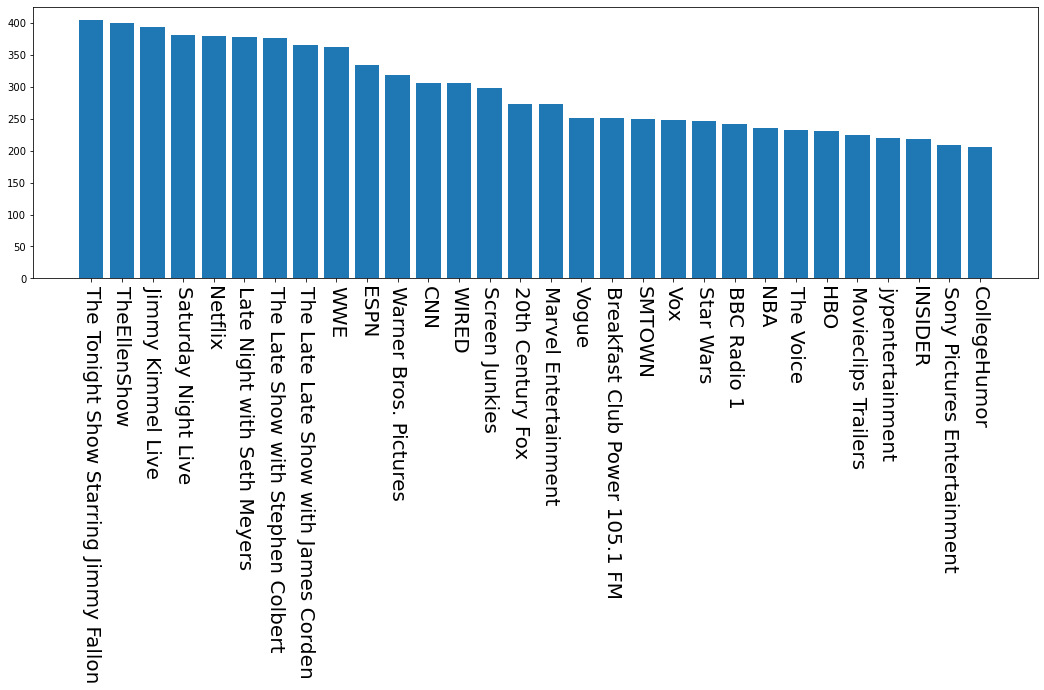

In [96]:
unique_channel_titles = unique_channel_titles[unique_channel_titles["count"] > 200]
plt.subplots(figsize=(18,5))
plt.bar(unique_channel_titles["channel_title"], unique_channel_titles["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()


### Rozkłady zmiennych logicznych


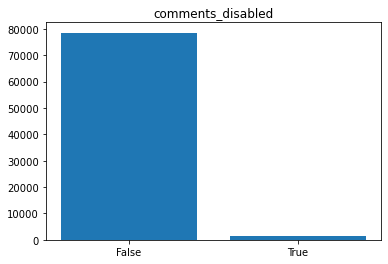

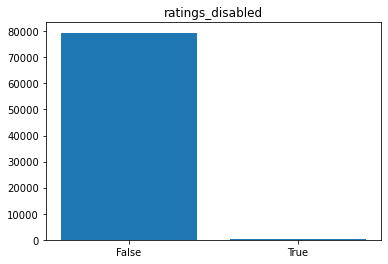

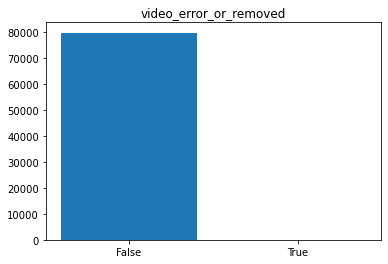

In [97]:
bool_attrs = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for attr in bool_attrs:
    attr_c = videos[attr].value_counts()
    attr_c = attr_c.rename_axis(attr).reset_index(name="count")
    plt.title(attr)
    plt.bar(["False", "True"], attr_c["count"])
    plt.show()

### Atrybuty liczbowe


ciekwaw spostrzerzenie - minimum like, dislike i commet są zerami,

na wykresie kategorii pominięto wartości nan, ponieważ jest ich bardzo dużo (obliczono niżej)

skomentować boxlpoty

In [98]:
videos.describe()

,category_id,views,likes,dislikes,comment_count
count,3932.000000,7.986500e+04,7.986500e+04,7.986500e+04,7.986500e+04
mean,18.459563,4.091166e+06,1.036262e+05,5.612328e+03,1.070850e+04
std,7.740292,1.439125e+07,2.957265e+05,4.124462e+04,4.443679e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,10.000000,2.464170e+05,5.642000e+03,2.010000e+02,6.420000e+02
50%,22.000000,7.961060e+05,2.092200e+04,7.120000e+02,2.099000e+03
75%,24.000000,2.535704e+06,7.824800e+04,2.527000e+03,7.220000e+03
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


['GB_category_id.json', 'US_category_id.json']
{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers', 29: 'Nonprofits & Activism'}
Liczby wartości 'nan'
Atrybut category_id: 75933
Atrybut views: 0
Atrybut likes: 0
Atrybut dislikes: 0
Atrybut comment_count: 0


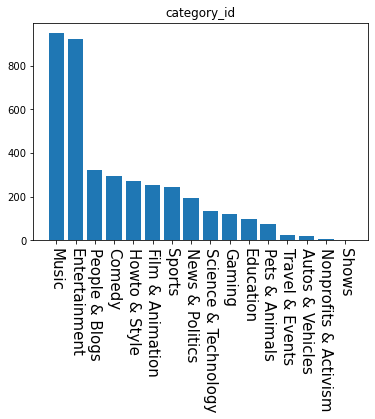

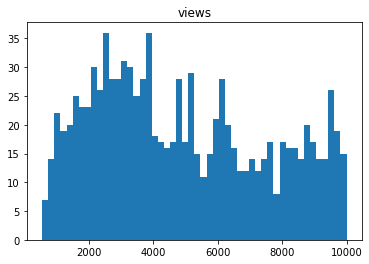

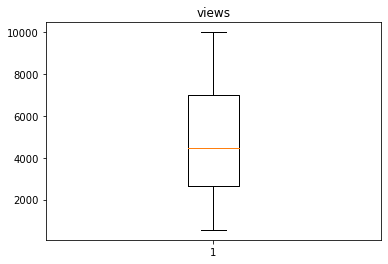

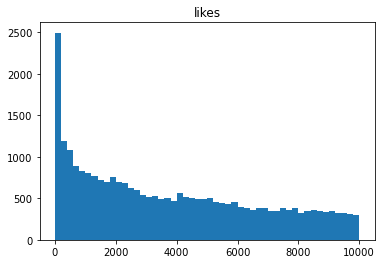

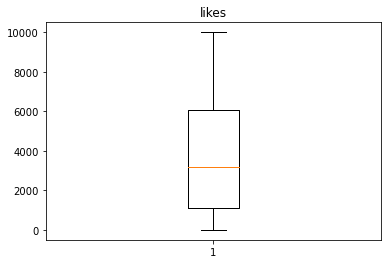

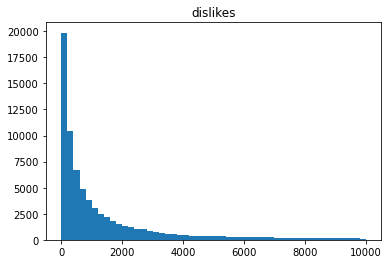

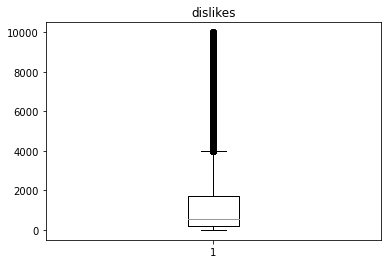

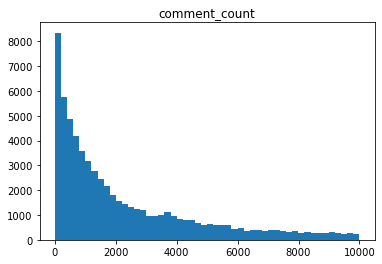

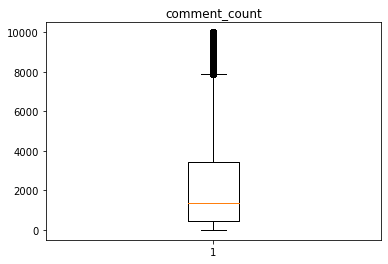

In [99]:
numeric_attrs = ["category_id", "views", "likes", "dislikes", "comment_count"]

nan_counts = dict()
categories_dict = get_categories_dict()

for attr in numeric_attrs:
    plt.title(attr)
    nan_counts[attr] = videos[attr].isna().sum()
    if attr !=  "category_id":
        table =  videos[videos[attr] < 10_000]
        plt.hist(table[attr], bins=50)
        # TODO better x axis - pomyśleć nad odrzuceniem obserwacji odstających
        plt.show()
        plt.title(attr)
        plt.boxplot(table[attr])
        plt.show()
    else:
        attr_c = videos[attr].value_counts()
        attr_c = attr_c.rename_axis(attr).reset_index(name="count")
        labels = [categories_dict[i] for i in attr_c[attr]]
        plt.bar(labels, attr_c["count"])
        plt.xticks(rotation=270, fontsize=15)
        plt.show()


print("Liczby wartości 'nan'")
for key in nan_counts.keys():
    print(f"Atrybut {key}: {nan_counts[key]}")

### Atrybuty tekstowe

In [100]:
string_attributes = ["video_id", "title", "channel_title", "tags",
                     "thumbnail_link", "description"]

# TODO preprocess description
# TODO preprocess title
print(videos["description"])

# TODO most frequent words in titles
# TODO most frequent words in descriptions


0        Click here to continue the story and make your...
1        Musical guest Taylor Swift performs …Ready for...
2        Eminem's new track Walk on Water ft. Beyoncé i...
3        Salford drew 4-4 against the Class of 92 and F...
4        Dashcam captures truck's near miss with child ...
                               ...                        
40944       The Cat Who Caught the Laser - Aaron's Animals
40945                                                  NaN
40946    I had so much fun transforming Safiyas hair in...
40947    How Black Panther Should Have EndedWatch More ...
40948    Call of Duty: Black Ops 4 Multiplayer raises t...
Name: description, Length: 79865, dtype: object


Video_id — słaby atrybut, ponieważ jest to tylko id generowane, nie wności żadniej wiedzy

Thumbnail link też słaby (jako sam tekst) - tylko link do obrazka, ale obrazek może wnieśc więcej wiedzy

Channel_title — być może słowa kluczowe będą znaczące ale ten atrubut chyba nie wności jakiejś
super wiedzy.

Zmienne logiczne, jeśli przyjmie wartość prawda to prawdopodobieństwo bycia
w trending znacznie spada.